In [2]:
import pandas as pd
import transformers 
import numpy as np
import torch
import datasets

from collections import OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import sys

sys.path.insert(0, '..')

from decompose_roberta import RobertaForSequenceClassificationDecomposed, RobertaConfig
from build_masks import build_masks


### Load Model

In [3]:
labels = ['awareness', 'change_of_location', 'change_of_state',
       'change_of_possession', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']

path = "../../combined_SPRL_roberta"
model = transformers.AutoModelForSequenceClassification.from_pretrained(path)

new_state_dict = OrderedDict()
for key, value in model.state_dict().items():
    # rename weight values in state_dict from roberta to bert
    new_key = key.replace("roberta", "bert")
    new_key = new_key.replace(
        "classifier.dense", "bert.pooler.dense").replace(
            "classifier.out_proj", "classifier")
    # ref : https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
    new_key = new_key.replace("LayerNorm.weight",
                           "LayerNorm.gamma").replace("LayerNorm.bias",
                                                       "LayerNorm.beta")
    new_state_dict[new_key] = value


In [4]:
decomposed_model = RobertaForSequenceClassificationDecomposed(
    config= RobertaConfig.from_dict(model.config.to_dict()),
    debug=False, 
    num_labels=len(labels) * 3
    )

tokenizer = transformers.AutoTokenizer.from_pretrained(path + "/tokenizer")
decomposed_model.model.load_state_dict(new_state_dict)
decomposed_model.model.eval()

model = decomposed_model.model


### Load Data

In [5]:
roles_wide = pd.read_csv("../../../dataV2/combined_V1_V2.csv", na_filter=False)
roles_wide.drop("Unnamed: 0", inplace=True, axis=1)

roles_wide.rename({"Sentence": "sentence", "Arg.Phrase": "arg"}, axis=1, inplace=True)

properties_list = ['awareness', 'change_of_location', 'change_of_state',
       'change_of_possession', 'existed_after', 'existed_before',
       'existed_during', 'instigation', 'sentient', 'volition']

print(roles_wide.shape)
roles_wide["combined_labels"] = roles_wide["combined_labels"].apply(lambda x: eval(x))
roles_wide.head()


(28810, 14)


,Sentence.ID,Gram.Func,sentence,Predicate,Split,arg,Arg.Stripped,arg_idx,verb_idx,structure,decomp_version,Pred.Lemma,modified_sentence,combined_labels
0,0003_21,nsubj,"In July , a gradual ban was imposed by the Env...",was imposed by,test,a gradual ban,a ban,"(3, 6)","(6, 9)",passive_full,V1,impose,1,"[1.0, 1.0, 3.0, 1.0, 5.0, 1.0, 5.0, 1.0, 1.0, ..."
1,0003_21,dobj,"In July , a gradual ban was imposed by the Env...",was imposed by,train,the Environmental Protection Agency,the Environmental Protection Agency,"(9, 13)","(6, 9)",passive_full,V1,impose,1,"[5.0, 1.0, 3.0, 1.0, 5.0, 5.0, 5.0, 5.0, 1.0, ..."
2,0003_29,nsubj,No bearing on our work force today is had by it .,is had by,train,No bearing on our work force today,no bearing,"(0, 7)","(7, 10)",passive_full,V1,have,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,0003_29,dobj,No bearing on our work force today is had by it .,is had by,test,it,It,"(10, 11)","(7, 10)",passive_full,V1,have,1,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 3.0, 2.0, ..."
4,0003_9,nsubj,A team of researchers from the National Cancer...,was led by,train,A team of researchers from the National Cancer...,a team,"(0, 19)","(19, 22)",passive_full,V1,lead,1,"[5.0, 3.0, 3.0, 1.0, 3.0, 3.0, 5.0, 3.0, 1.0, ..."


In [6]:
eval_df = roles_wide.loc[
    (roles_wide["decomp_version"] == "V2") & \
    (roles_wide["Split"] == "test")
    # (roles_wide["modified_sentence"] == 0)
    ][["Pred.Lemma", "Gram.Func", "structure", "sentence", "Predicate", "arg_idx", "verb_idx", "arg", "Arg.Stripped"]].drop_duplicates().reset_index()

print(eval_df.shape)
eval_df


(639, 10)


,index,Pred.Lemma,Gram.Func,structure,sentence,Predicate,arg_idx,verb_idx,arg,Arg.Stripped
0,14299,raise,nsubj,active_full,A girl raises her hand .,raises,"(0, 2)","(2, 3)",A girl,A girl
1,14301,raise,dobj,active_full,A girl raises her hand .,raises,"(3, 5)","(2, 3)",her hand,the hand
2,14303,be,nsubj,active_full,""" I 'm afraid not , "" explains Winston , "" tha...",is,"(11, 12)","(12, 13)",that,that
3,14305,say,nsubj,active_full,"In a timid voice , he says : "" If an airplane ...",says,"(5, 6)","(6, 7)",he,he
4,14307,beam,nsubj,active_full,""" Wonderful ! "" Winston beams .",beams,"(4, 5)","(5, 6)",Winston,Winston
...,...,...,...,...,...,...,...,...,...,...
634,21896,enjoy,nsubj,passive_full,The animations were enjoyed by me and wanted t...,were enjoyed by,"(0, 2)","(2, 5)",The animations,the animations
635,21898,have,nsubj,passive_full,A Full Color Catalog and Wholesale Price List ...,is had by,"(0, 14)","(14, 17)",A Full Color Catalog and Wholesale Price List ...,a Color Catalog and Price List
636,21900,have,dobj,passive_full,A Full Color Catalog and Wholesale Price List ...,is had by,"(17, 18)","(14, 17)",us,We
637,21902,accecpt,nsubj,passive_full,"Visa , MasterCard , Amex , Dinner s Club / Car...",are accecpted by,"(0, 19)","(19, 22)","Visa , MasterCard , Amex , Dinner s Club / Car...",Visa MasterCard Amex the Club / Carte Blanche ...


### Make Contribution Masks and Process Sentences

In [7]:
dataset, eval_df, lengths = build_masks(eval_df, tokenizer).values()
dataset



arg:  her hand
stripped arg:  the hand
arg reconstructed (no mod):  her hand
mod reconstructed:  her

arg:  Our plans
stripped arg:  the plans
arg reconstructed (no mod):  Our plans
mod reconstructed:  Our

arg:  Walter Kistler, LTS co-founder and Chairman
stripped arg:  Kistler
arg reconstructed (no mod):  Walter Kistler, LTS co-founder and Chairman
mod reconstructed:  Walter LTS co-founder and Chairman

arg:  the letter, signed by NASA Administrator Mike Griffin and the Pentagon's top space official, ex-astronaut Ron Sega
stripped arg:  the letter signed
arg reconstructed (no mod):  the letter, signed by NASA Administrator Mike Griffin and the Pentagon's top space official, ex-astronaut Ron Sega
mod reconstructed:  by NASA Administrator Mike Griffin and the Pentagon's top space official, ex-astronaut Ron Sega

arg:  The Sunni AMS
stripped arg:  The AMS
arg reconstructed (no mod):  The Sunni AMS
mod reconstructed:  Sunni

arg:  the right idea
stripped arg:  the idea
arg reconstructed

[{'sentence': '<a>A girl<a><p> raises<p> her hand.',
  'index': 14299,
  'arg': 'A girl',
  'stripped_arg': 'A girl',
  'gram': 'nsubj',
  'structure': 'active_full',
  'modifier_mask': array([0, 0]),
  'arg_nomod_mask': array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
  'arg_mod_mask': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'pred_mask': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])},
 {'sentence': 'A girl<p> raises<p><a> her hand<a>.',
  'index': 14301,
  'arg': 'her hand',
  'stripped_arg': 'the hand',
  'gram': 'dobj',
  'structure': 'active_full',
  'modifier_mask': array([1, 0]),
  'arg_nomod_mask': array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]),
  'arg_mod_mask': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
  'pred_mask': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])},
 {'sentence': '"I \'m afraid not", explains Winston, "<a> that<a><p> is<p> what we would call a GREAT LOSS".',
  'index': 14303,
  'arg': 'that',
  'stripped_arg': 'that',
  'gram': 'nsubj',
  'structure': 'active_ful

In [9]:
print(max(lengths))
eval_df.head()


76


,index,sentence,structure,gram,contribution,mask
0,14299,<a>A girl<a><p> raises<p> her hand.,active_full,nsubj,arg_nomod_mask,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,14301,A girl<p> raises<p><a> her hand<a>.,active_full,dobj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]"
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",active_full,nsubj,arg_nomod_mask,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [ ]:
max_length = 128

def tokenize_and_mask(t):
    encoded = tokenizer(t["sentence"], padding="max_length", truncation=True,
                        max_length=max_length, return_tensors="pt")
    beta_mask = np.pad(t["mask"], (0, max_length - len(t["mask"])%max_length), 'constant')
    beta_mask = torch.Tensor(beta_mask).to(int)

    # replace the masked tokens with tokenizer.eos_token_id
    mask_fill = tokenizer.eos_token_id
    encoded["input_ids_masked"] = encoded["input_ids"] * (1 - beta_mask) + mask_fill * beta_mask
    return encoded

test_set = datasets.Dataset.from_pandas(eval_df)
test_set = test_set.map(tokenize_and_mask)


Map:   0%|          | 0/1917 [00:00<?, ? examples/s]

In [ ]:
gen = test_set.iter(batch_size=4)
with torch.no_grad():
    for i, batch in enumerate(gen):
        attention_mask = torch.Tensor(batch["attention_mask"]).to(torch.int32).squeeze(1)
        input_ids = torch.Tensor(batch["input_ids"]).to(torch.int32).squeeze(1)

        l = model(input_ids=input_ids,
                  attention_mask=attention_mask).numpy()
        np.save(f"mask(eos)_logits_roberta/batch_{i}_logits.npy", l)
        if i % 10 == 0:
            print(i)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470


### Analyze Contributions


In [ ]:
logits = []
for i in range(480):
    a = np.load(f"mask(eos)_logits_roberta/batch_{i}_logits.npy")
    logits.append(a)

logits = np.concatenate(logits, axis=0).reshape(-1, 3, 10)
logits.shape


(1917, 3, 10)

In [ ]:
logits_full = []
for i in range(480):
    a = np.load(f"gcd_logits_roberta/batch_{i}_logits.npy").sum(0)
    logits_full.append(a)

logits_full = np.concatenate(logits_full, axis=0).reshape(-1, 3, 10)
logits_full.shape


(1917, 3, 10)

In [ ]:
logits_beta = logits_full - logits

eval_df["beta_contribution"] = (logits_beta / logits_full).tolist()
eval_df["span_length"] = eval_df["mask"].apply(lambda x: x.astype(int).sum()).replace(0, np.nan)
eval_df.dropna(subset="span_length", inplace=True)
eval_df["beta_contribution"] = eval_df.apply(
    lambda x: np.array(x["beta_contribution"])/(np.array(x["mask"]).astype(int).sum()),
    axis=1
)

eval_df.head()   


,index,sentence,structure,gram,contribution,mask,beta_contribution,span_length
0,14299,<a>A girl<a><p> raises<p> her hand.,active_full,nsubj,arg_nomod_mask,"[False, False, True, True, False, False, False...","[[0.003009504049222693, -0.19010329837319323, ...",2.0
1,14301,A girl<p> raises<p><a> her hand<a>.,active_full,dobj,arg_nomod_mask,"[False, False, False, False, False, False, Fal...","[[-0.20358421542742397, 0.15828079682913337, 0...",1.0
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",active_full,nsubj,arg_nomod_mask,"[False, False, False, False, False, False, Fal...","[[0.2674752816264592, 0.4537424667341692, -2.4...",1.0
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",active_full,nsubj,arg_nomod_mask,"[False, False, False, False, False, False, Fal...","[[-0.014249192666376483, 0.3944571444692082, -...",1.0
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",active_full,nsubj,arg_nomod_mask,"[False, False, False, False, False, False, Tru...","[[-0.20449631633185922, -1.559432500644218, -3...",1.0


In [ ]:
contributions_df = eval_df[["index", "sentence", "structure", "gram", "contribution", "beta_contribution"]]
contributions_df[labels] = contributions_df['beta_contribution'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

contributions_df = contributions_df.melt(
    id_vars=["sentence", "index", "contribution", "gram", "structure"], value_vars=labels, value_name="logits",
    var_name="property")
contributions_df[["negative", "neutral", "positive"]] = contributions_df['logits'].apply(lambda x: pd.Series(np.array(x).T.tolist()))

spans = {
    "arg_nomod": "argument",
    "arg_mod": "modifier",
    "pred": "predicate"
}
contributions_df["span"] = contributions_df["contribution"].apply(
    lambda x: spans["_".join(x.split("_")[:-1])])
contributions_df = contributions_df.melt(id_vars=[ "index", "sentence","span", "property", "gram", "structure"],
                      value_vars=["negative", "neutral", "positive"],
                      var_name="class", value_name="per_token_contribution")

contributions_df["structure"] = contributions_df["structure"].apply(
    lambda x: "_".join(x.split("_")[:-1]))
contributions_df.head()


/var/folders/lq/kd3wh6952vg99n5ppf4srz9w0000gn/T/ipykernel_15071/2046754261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contributions_df[labels] = contributions_df['beta_contribution'].apply(lambda x: pd.Series(np.array(x).T.tolist()))


,index,sentence,span,property,gram,structure,class,per_token_contribution
0,14299,<a>A girl<a><p> raises<p> her hand.,argument,awareness,nsubj,active,negative,0.003010
1,14301,A girl<p> raises<p><a> her hand<a>.,argument,awareness,dobj,active,negative,-0.203584
2,14303,"""I 'm afraid not"", explains Winston, ""<a> that...",argument,awareness,nsubj,active,negative,0.267475
3,14305,"In a timid voice,<a> he<a><p> says<p>: ""If an ...",argument,awareness,nsubj,active,negative,-0.014249
4,14307,"""Wonderful!""<a> Winston<a><p> beams<p>.",argument,awareness,nsubj,active,negative,-0.204496


In [ ]:
percentiles_df = []
n = 20

for span in ["argument", "modifier", "predicate"]:
    for p in np.arange(n + 1) * (100/n):
        x = np.nanpercentile(
        contributions_df.loc[contributions_df["span"] == span]["per_token_contribution"].to_numpy(),
        [p])[0]

        percentiles_df.append({
            "span": span,
            "percentile": p,
            "stat": x
        })

percentiles_df = pd.DataFrame(percentiles_df).pivot(index="percentile", values="stat", columns="span")
percentiles_df


span,argument,modifier,predicate
percentile,,,
0.0,-627.397272,-193.813507,-627.397274
5.0,-0.341233,-0.277165,-0.387722
10.0,-0.155383,-0.125717,-0.180292
15.0,-0.095227,-0.070782,-0.109992
20.0,-0.062571,-0.043333,-0.071123
25.0,-0.041994,-0.027921,-0.046864
30.0,-0.027176,-0.018308,-0.030378
35.0,-0.017250,-0.011366,-0.019401
40.0,-0.009723,-0.006424,-0.011289


In [ ]:
lower, upper = np.nanpercentile(contributions_df["per_token_contribution"].to_numpy(), [5, 95])
print(f"clipping outliers less than {lower} or greater than {upper}")
contributions_df["per_token_contribution_"] = contributions_df["per_token_contribution"].apply(
    lambda x: np.clip(x, a_min=0, a_max=upper)
)


clipping outliers less than -0.3498332641100517 or greater than 0.3988860765817071


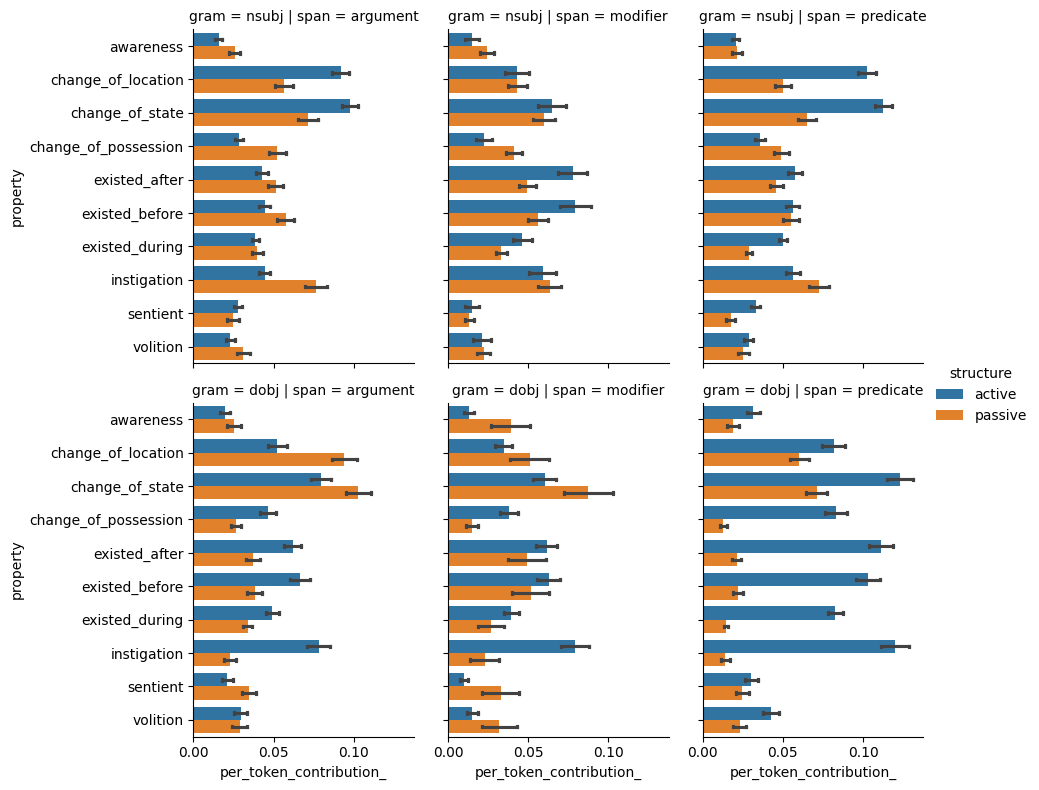

In [ ]:
sns.catplot(
    contributions_df.loc[contributions_df["gram"] != "iobj"], col="span", kind="bar", hue="structure", orient="h", row="gram", 
    y = "property", x = "per_token_contribution_", errorbar="se", height=4, capsize=0.1,
    aspect=0.8)


/var/folders/lq/kd3wh6952vg99n5ppf4srz9w0000gn/T/ipykernel_15071/3166804136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df["class"] = c_df["class"].replace("negative", "negative (1-2)"


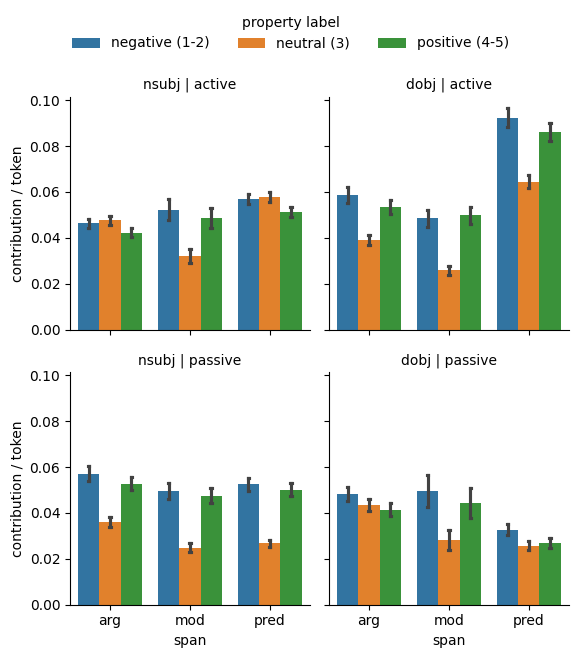

In [ ]:
c_df = contributions_df.loc[contributions_df["gram"] != "iobj"]
c_df["class"] = c_df["class"].replace("negative", "negative (1-2)"
                                      ).replace("neutral", "neutral (3)"
                                                ).replace("positive", "positive (4-5)")

ax = sns.catplot(
    c_df, kind="bar", row = "structure", col="gram",
    x = "span", y = "per_token_contribution_", hue="class", errorbar="se", capsize=0.05, height=3,
    sharey=True)
ax.set_titles("{col_name} | {row_name}")
ax.set_xticklabels(["arg", "mod", "pred"])
ax.set_axis_labels("span", "contribution / token")

sns.move_legend(ax, "lower center", bbox_to_anchor=(0.42, 1), ncol=3,
                title="property label", frameon=False)
